In [1]:
import pandas as pd
import re
import nltk
import spacy
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import math
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [2]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")
from nltk.tokenize import sent_tokenize, word_tokenize

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/zhangnaichuan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhangnaichuan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
path = "Scripts TBBT.csv" 
df = pd.read_csv(path , sep = "," , skipinitialspace=True, engine="python")
df.head()


,episode_name,dialogue,person_scene
0,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Scene
1,Series 01 Episode 01 – Pilot Episode,So if a photon is directed through a plane wi...,Sheldon
2,Series 01 Episode 01 – Pilot Episode,"Agreed, what’s your point?",Leonard
3,Series 01 Episode 01 – Pilot Episode,"There’s no point, I just think it’s a good id...",Sheldon
4,Series 01 Episode 01 – Pilot Episode,Excuse me?,Leonard


In [4]:
# list of distinct characters in person_scene column
characters = df['person_scene'].unique()
# characters

In [5]:
def clean_text(text):
    # clean punctuation
    text = re.sub(r"[!”#$%&()*+,-.:;?@[\]^_`{|}~]", "", str(text))
    # lower
    return text.lower()

In [6]:
def process_words(text):
    # tokenization
    sentences = nltk.tokenize.sent_tokenize(text)
    words = nltk.tokenize.word_tokenize(text)
    # remove stopwords
    stop_words = set(nltk.corpus.stopwords.words('english') + ["i'm", "oh", "well"])
    filter_words = [word for word in words if word not in stop_words]
    filter_words = [word for word in filter_words if word != "’"]
    # stemming 
    porter = nltk.stem.PorterStemmer()
    stemmed_words = [porter.stem(word) for word in filter_words]
    return {
        "sentences" : sentences,
        "filtered_words" : filter_words,
        "stemmed_words" : stemmed_words
    }

In [7]:
def pos_ner(text):
    doc = nlp(text)
    pos_tag = [(token.text, token.pos_) for token in doc]
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return {
        "pos_tags": pos_tag,
        "entities" : entities
    }

In [8]:
Amy = df[df['person_scene'].str.contains('Amy')]
data_amy = Amy['dialogue']

processed_data_amy = []
for text in data_amy:
    cleaned = clean_text(text)
    processed = process_words(cleaned)
    ner_pos = pos_ner(" ".join(processed["filtered_words"]))
    processed_data_amy.append({
        "org_text": text,
        "cleaned_text": cleaned,
        "filtered_words": processed["filtered_words"],
        "stemmed_words": processed["stemmed_words"],
        "pos_tags": ner_pos["pos_tags"],
        'entities': ner_pos['entities']
    }
    )

In [9]:
for i, data in enumerate(processed_data_amy):
    if "pos_tags" not in data:
        print(f"Missing 'pos_tags' in entry {i}: {data_amy}")

In [10]:
Amy['filtered_words'] = [data_amy['filtered_words'] for data_amy in processed_data_amy]
Amy['stemmed_words'] = [data_amy['stemmed_words'] for data_amy in processed_data_amy]
Amy['pos_tags'] = [data_amy["pos_tags"] for data_amy in processed_data_amy]
Amy['entities'] = [data_amy['entities'] for data_amy in processed_data_amy]

In [11]:
Amy.head()

,episode_name,dialogue,person_scene,filtered_words,stemmed_words,pos_tags,entities
15116,Series 03 Episode 23 – The Lunar Excitation,Excuse me. I’m Amy Farrah Fowler. You’re Sheld...,Amy,"[excuse, amy, farrah, fowler, sheldon, cooper]","[excus, ami, farrah, fowler, sheldon, cooper]","[(excuse, VERB), (amy, ADV), (farrah, PROPN), ...","[(farrah fowler, PERSON), (sheldon cooper, PER..."
15118,Series 03 Episode 23 – The Lunar Excitation,"If that was slang, I’m unfamiliar with it. If...",Amy,"[slang, unfamiliar, literal, share, aversion, ...","[slang, unfamiliar, liter, share, avers, soil,...","[(slang, PROPN), (unfamiliar, PROPN), (literal...","[(slang, ORG), (date least year, DATE)]"
15120,Series 03 Episode 23 – The Lunar Excitation,"I don’t object to the concept of a deity, but...",Amy,"[object, concept, deity, baffled, notion, one,...","[object, concept, deiti, baffl, notion, one, t...","[(object, NOUN), (concept, NOUN), (deity, NOUN...",[]
15122,Series 03 Episode 23 – The Lunar Excitation,"Noted. Now, before this goes any further, you...",Amy,"[noted, goes, know, forms, physical, contact, ...","[note, goe, know, form, physic, contact, inclu...","[(noted, VERB), (goes, VERB), (know, VERB), (f...",[]
15124,Series 03 Episode 23 – The Lunar Excitation,"Tepid water, please.",Amy,"[tepid, water, please]","[tepid, water, pleas]","[(tepid, NOUN), (water, NOUN), (please, INTJ)]",[]


In [12]:
Amy.to_csv('processed_data_amy.csv', index=False)

## Question 1 

On average, how many sentences and words does your character have to speak per episode? Does this deviate across seasons?

In [13]:
Amy['season'] = Amy['episode_name'].str.extract(r'Series (\d+)').astype(int)
Amy['episode'] = Amy['episode_name'].str.extract(r'Episode (\d+)').astype(int)

In [14]:
def calculate_counts(dialogue):
    sentences = nltk.sent_tokenize(dialogue)
    words = nltk.word_tokenize(dialogue)
    return len(sentences), len(words)


In [15]:
# Apply to calculate sentence and word counts for Amy
Amy[['sentence_count', 'word_count']] = Amy['dialogue'].apply(
    lambda x: pd.Series(calculate_counts(x))
)

amy_stats = Amy.groupby(["season", "episode"]).agg(
    total_sentences =("sentence_count", "sum"),
    total_words = ("word_count", "sum"),
).reset_index()

amy_stats["avg_sentences_per_episode"] = amy_stats["total_sentences"]
amy_stats["avg_words_per_episode"] = amy_stats["total_words"]

amy_season_stats = amy_stats.groupby(["season"]).agg(
    total_sentences =("avg_sentences_per_episode", "mean"),
    total_words = ("avg_words_per_episode", "mean"),
).reset_index()


In [16]:
amy_stats

,season,episode,total_sentences,total_words,avg_sentences_per_episode,avg_words_per_episode
0,3,23,10,126,10,126
1,4,1,23,172,23,172
2,4,3,63,587,63,587
3,4,5,32,264,32,264
4,4,8,70,744,70,744
...,...,...,...,...,...,...
149,10,20,30,282,30,282
150,10,21,33,256,33,256
151,10,22,33,316,33,316
152,10,23,67,606,67,606


In [17]:
amy_season_stats

,season,total_sentences,total_words
0,3,10.000000,126.000000
1,4,40.600000,397.733333
2,5,34.476190,352.761905
3,6,31.318182,291.545455
4,7,31.083333,285.500000
5,8,28.916667,280.375000
6,9,33.826087,303.478261
7,10,40.083333,373.125000


In [18]:
# Apply to calculate sentence and word counts for bernadette
Amy[['sentence_count', 'word_count']] = Amy['dialogue'].apply(
    lambda x: pd.Series(calculate_counts(x))
)

amy_stats = Amy.groupby(["season", "episode"]).agg(
    total_sentences =("sentence_count", "sum"),
    total_words = ("word_count", "sum"),
).reset_index()

amy_stats["avg_sentences_per_episode"] = amy_stats["total_sentences"]
amy_stats["avg_words_per_episode"] = amy_stats["total_words"]

amy_season_stats = amy_stats.groupby(["season"]).agg(
    total_sentences =("avg_sentences_per_episode", "mean"),
    total_words = ("avg_words_per_episode", "mean"),
).reset_index()


In [35]:
# tokenize again for counting
def calculate_counts(dialogue):
    sentences = nltk.sent_tokenize(dialogue)
    words = nltk.word_tokenize(dialogue)
    return len(sentences), len(words)

# Apply to function
Amy[['sentence_count', 'word_count']] = Amy['dialogue'].apply(
    lambda x: pd.Series(calculate_counts(x))
)

# Extract season and episode information
Amy['season'] = Amy['episode_name'].str.extract(r'Series (\d+)')
Amy['episode'] = Amy['episode_name'].str.extract(r'Episode (\d+)')

# Group by season and episode
character_episode_stats = Amy.groupby(['season', 'episode']).agg(
    total_sentences=('sentence_count', 'sum'),
    total_words=('word_count', 'sum'),
).reset_index()

# Calculate per season avg
season_stats = character_episode_stats.groupby(['season']).agg(
    avg_sentences_per_episode=('total_sentences', 'mean'),
    avg_words_per_episode=('total_words', 'mean')
).reset_index()

# Calculate per season deviations
season_dev = character_episode_stats.groupby(['season']).agg(
    sentences_per_episode_dev=('total_sentences', 'mean'),
    words_per_episode_dev=('total_words', 'mean')
).reset_index()

In [36]:
print(season_stats)

  season  avg_sentences_per_episode  avg_words_per_episode
0     03                  10.000000             126.000000
1     04                  40.600000             397.733333
2     05                  34.476190             352.761905
3     06                  31.318182             291.545455
4     07                  31.083333             285.500000
5     08                  28.916667             280.375000
6     09                  33.826087             303.478261
7     10                  40.083333             373.125000


## Question 2
Globally, over all episodes within the first 10 seasons, how many times does your character mention nouns, and person names? Make a Wordcloud of this tag/entity to have a clear visualization which nouns/person names are mostly used by your character.


In the function count_nouns, we use a list comprehension to filter out tags that are nouns (tag[1] in ['NOUN']). The len function then counts the number of such tags.
Then we apply count_nouns function to Amy dataframe to create a new column 'noun_count' that count the number of nouns in each row.
Secondly, we groups the DataFrame Amy by season and episode and then aggregates the noun counts within each group. We now obtain a new dataframe Amy_noun_stats, which contains the total noun counts for each season and episode.

In [20]:
# count how many times Amy mention nouns given pos_tags column
def count_nouns(pos_tags):
    return len([tag for tag in pos_tags if tag[1] in ['NOUN']])
Amy['noun_count'] = Amy['pos_tags'].apply(count_nouns)



# sum the noun counts
Amy_noun_stats = Amy.groupby(["season", "episode"]).agg(
    total_nouns =("noun_count", "sum"),
).reset_index()

# Amy
Amy_noun_stats


,season,episode,total_nouns
0,3,23,18
1,4,1,31
2,4,3,90
3,4,5,53
4,4,8,121
...,...,...,...
149,10,20,34
150,10,21,28
151,10,22,36
152,10,23,46


In the function count_persons, we use a list comprehension to filter out entity that is 'PERSON'. The len function then counts the number of such entity.
Then we apply count_persons function to Amy dataframe to create a new column 'person_count' that count the number of person in each row.
Secondly, we groups the DataFrame Amy by season and episode and then aggregates the person counts within each group. We now obtain a new dataframe Amy_person_stats, which contains the total person counts for each season and episode.

In [21]:
# count how many times Amy mentions person names given entities column
def count_persons(entities):
    return len([ent for ent in entities if ent[1] == 'PERSON'])
Amy['person_count'] = Amy['entities'].apply(count_persons)

# sum the person counts
Amy_person_stats = Amy.groupby(["season", "episode"]).agg(
    total_persons =("person_count", "sum"),
).reset_index()

Amy_person_stats

,season,episode,total_persons
0,3,23,2
1,4,1,1
2,4,3,0
3,4,5,3
4,4,8,3
...,...,...,...
149,10,20,6
150,10,21,2
151,10,22,1
152,10,23,4


First, we create a new DataFrame Amy_noun from an existing Amy['pos_tags'] column, which contains part-of-speech tags. Each list-like element in the pos_tags column is transformed into separate rows. 

Secondly, we filter the DataFrame to retain only the rows where the pos_tags indicates a noun and create a new column named noun that extracts the actual noun from the pos_tags column by taking the first element (index 0) of the pos_tags string.

Third, we create a new DataFrame Amy_noun_count by grouping the DataFrame Amy_noun by the noun column and counts the occurrences of each noun using the size() method. The Amy_noun_count dataframe is sorted by the count column in descending order

In [22]:
# create a dataframe listing count of nouns and which nouns mentioned by Amy
Amy_nouns = Amy['pos_tags'].explode().reset_index()
Amy_nouns.columns = ['index', 'pos_tags']
# Amy_nouns
# filter only nouns
Amy_nouns = Amy_nouns[Amy_nouns['pos_tags'].str[1] == 'NOUN']
Amy_nouns['noun'] = Amy_nouns['pos_tags'].str[0]
# Amy_nouns

# count the nouns
Amy_noun_count = Amy_nouns.groupby('noun').size().reset_index()
Amy_noun_count.columns = ['noun', 'count']

# sort the nouns by count
Amy_noun_count = Amy_noun_count.sort_values(by='count', ascending=False)
Amy_noun_count

,noun,count
1822,sheldon,166
2107,time,80
1479,penny,72
1370,night,66
1480,people,45
...,...,...
924,handmedowns,1
920,hammers,1
917,half,1
916,haircut,1


Finally, we create a word cloud of Amy's dialog based on Amy_noun_count. 

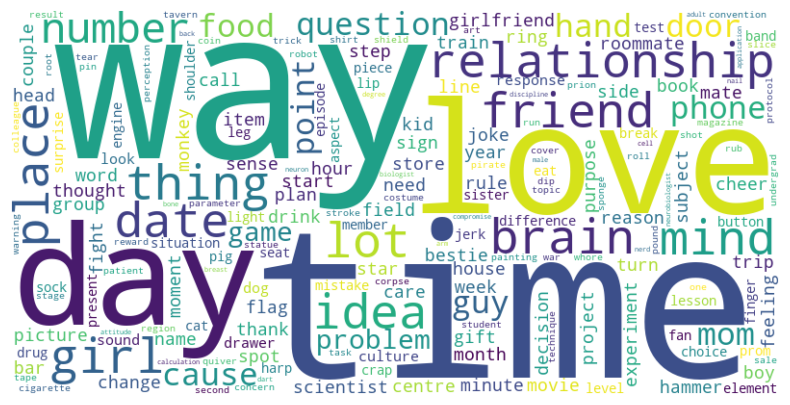

In [23]:
# make a word cloud of the nouns mentioned by Bernadette using Bernadette_noun_count
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(' '.join(Amy_noun_count['noun']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Question 3

In [38]:
# Basic data manipulation steps. 
Amy['season_episode'] = Amy['season'].astype(str) + '-' + Amy['episode'].astype(str)
dialogue_list = Amy['filtered_words'].sum()

This part of code used TF-IDF (Term Frequency-Inverse Document Frequency) matrix. The `TfidfVectorizer` converts the raw text into a matrix of TF-IDF features. This matrix is a sparse matrix where each row corresponds to a document and each column corresponds to a term, with values representing the TF-IDF scores.

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(dialogue_list)
feature_names = tfidf_vectorizer.get_feature_names_out()

In [26]:
import numpy as np

def get_top_words(tfidf_matrix, feature_names, top_n=3):
    scores = np.sum(tfidf_matrix, axis=0).A1  # Sum TF-IDF scores across rows
    top_indices = np.argsort(scores)[::-1][:top_n]
    return [(feature_names[i], scores[i]) for i in top_indices]

This part of code shows the top 50 words of Amy in all seasons. The top 1 word "Sheldon" shows the pivotal role their relationship plays in her life. Amy's frequent use of words related to knowledge and thinking like "know" and "think" aligns with her scientific background and intellectual personality. Words like "love," "feel," and "want" suggest her emotional development and increasing expressiveness. The use of action-oriented words like "get", "go", "take", "make" indicates her growing confidence and assertiveness. 

In [27]:
total_tfidf_matrix = tfidf_vectorizer.fit_transform(dialogue_list)
top_10_words = get_top_words(tfidf_matrix, feature_names, top_n=50)
for i, word in enumerate(top_10_words):
    print(f"Top {i+1} Words:", word[0])

Top 1 Words: sheldon
Top 2 Words: know
Top 3 Words: like
Top 4 Words: get
Top 5 Words: one
Top 6 Words: okay
Top 7 Words: think
Top 8 Words: go
Top 9 Words: right
Top 10 Words: want
Top 11 Words: really
Top 12 Words: good
Top 13 Words: going
Top 14 Words: would
Top 15 Words: penny
Top 16 Words: let
Top 17 Words: got
Top 18 Words: na
Top 19 Words: could
Top 20 Words: gon
Top 21 Words: time
Top 22 Words: see
Top 23 Words: say
Top 24 Words: leonard
Top 25 Words: little
Top 26 Words: night
Top 27 Words: sure
Top 28 Words: sorry
Top 29 Words: come
Top 30 Words: yes
Top 31 Words: make
Top 32 Words: feel
Top 33 Words: back
Top 34 Words: us
Top 35 Words: take
Top 36 Words: maybe
Top 37 Words: mean
Top 38 Words: look
Top 39 Words: need
Top 40 Words: something
Top 41 Words: two
Top 42 Words: bernadette
Top 43 Words: never
Top 44 Words: thank
Top 45 Words: uh
Top 46 Words: said
Top 47 Words: first
Top 48 Words: nice
Top 49 Words: way
Top 50 Words: love


Below shows the top 3 words from every season that Amy mentioned. We can find that at Season 3, Amy feels unsure. From Season 4 to 10, "Sheldon" becomes a very important word, indicating that the relationship between Amy and Sheldon begin to develop. The word "like" has two main meanings, "feel enjoyable" and "meaningless word used in speech", indicating that Amy begins to love Sheldon but still feels unsure or wants to express some opinions. From Season 7 to 10, "get" and "know" show more agreement to some suggestions, indicating that Amy tends to agree with others and accept other's instructions.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

## Season Level
# Grouping by Season
season_dialogues = Amy.groupby('season')['filtered_words'].apply(lambda x: ' '.join(sum(x, [])))
season_tfidf_matrix = tfidf_vectorizer.fit_transform(season_dialogues)

# Get top words for each season
for season, tfidf_matrix in enumerate(season_tfidf_matrix):
    top_words = get_top_words(tfidf_matrix, feature_names)
    print(f"Season {season + 3} Top Words:")
    for i in range(len(top_words)):
        print(i+1, top_words[i][0])
    print()

Here shows the top 3 important words per episode. Here is a special episode 3-23. Season 3 only contains this one episode, but top 3 words in season 3 is different from the top 3 words in episode 3-23. This is because TF-IDF weighting yields different results in different steps. 

In [32]:
## Episode level
# Grouping by episode 
episode_dialogues = Amy.groupby('season_episode')['filtered_words'].apply(lambda x: ' '.join(sum(x, [])))
episode_tfidf_matrix = tfidf_vectorizer.fit_transform(episode_dialogues)

# Get top words for each episode 
episodes = Amy['season_episode'].unique()
for i, tfidf_matrix in enumerate(episode_tfidf_matrix):
    print(f"Episode {episodes[i]} Top Words:", get_top_words(tfidf_matrix, feature_names))
    print()

Episode 3-23 Top Words: [('disrespectful', np.float64(0.25876548768703617)), ('hotter', np.float64(0.23915522113870036)), ('airport', np.float64(0.23915522113870036))]

Episode 4-1 Top Words: [('selfish', np.float64(0.3021808770182763)), ('keep', np.float64(0.2010796771826711)), ('little', np.float64(0.19995556394325714))]

Episode 4-3 Top Words: [('scotch', np.float64(0.23486865685387173)), ('trains', np.float64(0.21706938614770793)), ('birthday', np.float64(0.1866413318976998))]

Episode 4-5 Top Words: [('blah', np.float64(0.4570175920643392)), ('help', np.float64(0.1748499978270061)), ('mother', np.float64(0.16630169782577217))]

Episode 4-8 Top Words: [('miss', np.float64(0.3353119733506522)), ('bye', np.float64(0.2779953327347307)), ('girls', np.float64(0.25148398001298916))]

Episode 4-10 Top Words: [('machine', np.float64(0.28393743686686135)), ('smudge', np.float64(0.2284090494199755)), ('looking', np.float64(0.22274973873286458))]

Episode 4-13 Top Words: [('choir', np.float64

Then, we print out the word cloud figure of Amy's lines of all seasons. 

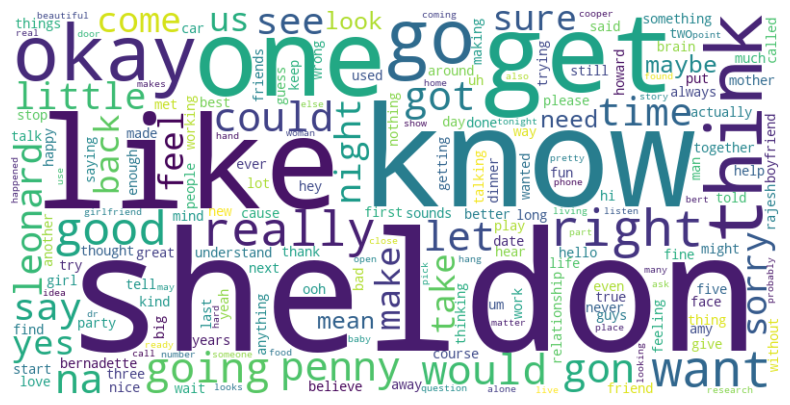

In [39]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordcloud(tfidf_matrix, feature_names):
    scores = np.sum(tfidf_matrix, axis=0).A1
    word_scores = {feature_names[i]: scores[i] for i in range(len(scores))}
    wc = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_scores)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

plot_wordcloud(total_tfidf_matrix, feature_names)

## Question 4

Examine the co-occurence of words for your character by using the Positive Poin twise Mutual Information measurement. Which words are commonly used together in his/her dialogues? Remark: You can try to make a Word-Word co-occurence matrix.

In [43]:
import ast
df = pd.read_csv('processed_data_amy.csv')


# If df['filtered_words'] contains string representations of lists/dicts:
df['filtered_words'] = df['filtered_words'].apply(lambda x: ast.literal_eval(x))

# Now tokenized_sentences is simply the Series with evaluated values
tokenized_sentences = df['filtered_words']
print(tokenized_sentences)

0          [excuse, amy, farrah, fowler, sheldon, cooper]
1       [slang, unfamiliar, literal, share, aversion, ...
2       [object, concept, deity, baffled, notion, one,...
3       [noted, goes, know, forms, physical, contact, ...
4                                  [tepid, water, please]
                              ...                        
3415                                            [missing]
3416                                                   []
3417                                                 [hi]
3418    [uhhuh, hang, answering, phone, hello, little,...
3419                                          [important]
Name: filtered_words, Length: 3420, dtype: object


In [44]:
# Flatten the list and get unique words
total_words = [word for sentence in tokenized_sentences for word in sentence]
unique_words = list(set(total_words))


# Removing duplicates 
unique_words = list(set(total_words))

# Save or print the result
print(f"Total Words: {len(total_words)}")
print(f"Unique Words: {len(unique_words)}")
print(unique_words[:20])  # Preview 20 unique words

Total Words: 17178
Unique Words: 4697
['slats', '1800s', 'sitting', 'marie', 'laid', 'best', 'acrylic', 'distinguished', 'kathy', 'prom', 'activated', 'bitchiness', 'eel', 'jewel', 'heh', 'limbic', 'sample', 'monoamine', 'worse', 'perfectly']


In [45]:
#co-occurence matrix with undetermined window size
def build_cooccurrence_matrix(tokenized_sentences, window_size=None):
    unique_words = set(word for sentence in tokenized_sentences for word in sentence)
    unique_words = list(unique_words)
    word_to_id = {word: idx for idx, word in enumerate(unique_words)}
    id_to_word = {idx: word for word, idx in word_to_id.items()}
    cooccurrence_matrix = np.zeros((len(unique_words), len(unique_words)))

    for sentence in tokenized_sentences:
        for idx, word in enumerate(sentence):
            word_id = word_to_id[word]

            # Look at words within the context window
            start = max(idx - window_size, 0)
            end = min(idx + window_size + 1, len(sentence))
            
            for context_idx in range(start, end):
                if idx != context_idx:
                    context_word = sentence[context_idx]
                    context_id = word_to_id[context_word]
                    cooccurrence_matrix[word_id, context_id] += 1

    return cooccurrence_matrix, word_to_id, id_to_word

In [46]:
#compute PPMI

def compute_ppmi(cooccurrence_matrix):
    total_count = np.sum(cooccurrence_matrix)
    word_sums = np.sum(cooccurrence_matrix, axis=1)
    ppmi_matrix = np.zeros_like(cooccurrence_matrix)

    for i in range(cooccurrence_matrix.shape[0]):
        for j in range(cooccurrence_matrix.shape[1]):
            if cooccurrence_matrix[i, j] > 0:
                p_ij = cooccurrence_matrix[i, j] / total_count
                p_i = word_sums[i] / total_count
                p_j = word_sums[j] / total_count
                ppmi = max(np.log2(p_ij / (p_i * p_j)), 0)
                ppmi_matrix[i, j] = ppmi
    return ppmi_matrix

In [48]:
def top_word_pairs(ppmi_matrix, id_to_word, top_n=20):
    word_pairs = []

    # Extracting non-diagonal word pairs where PPMI > 0
    for i in range(ppmi_matrix.shape[0]):
        for j in range(i+1, ppmi_matrix.shape[1]):  # Ignore the diagonal
            if ppmi_matrix[i, j] > 0:
                word_pairs.append((id_to_word[i], id_to_word[j], ppmi_matrix[i, j]))

    # sorting by descending order
    sorted_pairs = sorted(word_pairs, key=lambda x: x[2], reverse=True)
    return sorted_pairs[:top_n]

In [49]:
# Co-occurrence matrix
cooccurrence_matrix, word_to_id, id_to_word = build_cooccurrence_matrix(tokenized_sentences, window_size=2)

# Computing PPMI
ppmi_matrix = compute_ppmi(cooccurrence_matrix)

# Top 20 word pairs
top_pairs = top_word_pairs(ppmi_matrix, id_to_word, top_n=20)

# Results
for word1, word2, score in top_pairs:
    w1_id = word_to_id[word1]
    w2_id = word_to_id[word2]
    # co-occurrence count in the matrix
    co_occurrence_count = cooccurrence_matrix[w1_id, w2_id]  # or cooccurrence_matrix[w2_id, w1_id]
    print(f"{word1} - {word2}: PPMI={score:.2f}, Co-occurrence Count={co_occurrence_count:.0f}")

bayonets - tuned: PPMI=15.62, Co-occurrence Count=1
atomic - magnets: PPMI=15.62, Co-occurrence Count=1
equipment - sporting: PPMI=15.62, Co-occurrence Count=1
accept - graciously: PPMI=15.62, Co-occurrence Count=1
freaking - pigs: PPMI=15.62, Co-occurrence Count=1
mandarin - sings: PPMI=15.62, Co-occurrence Count=1
sailing - traffic: PPMI=15.62, Co-occurrence Count=1
episodes - 232: PPMI=15.62, Co-occurrence Count=1
unit - storage: PPMI=15.62, Co-occurrence Count=1
pun - intended: PPMI=15.62, Co-occurrence Count=1
lowhanging - fruit: PPMI=15.62, Co-occurrence Count=1
rising - rapidly: PPMI=15.62, Co-occurrence Count=1
crew - cleanup: PPMI=15.62, Co-occurrence Count=1
yup - killin: PPMI=15.62, Co-occurrence Count=1
barking - metatarsal: PPMI=15.62, Co-occurrence Count=1
yo - pdog: PPMI=15.62, Co-occurrence Count=1
lawyer - gotten: PPMI=14.03, Co-occurrence Count=1
disorder - obsessivecompulsive: PPMI=14.03, Co-occurrence Count=1
quivers - uterus: PPMI=14.03, Co-occurrence Count=1
forgo

From the output of the top 20 words, we can see that about 15 pairs have a PPMI score of 15.31. Size-si, quivers-uterus and obsessivecompulsive - disorder have a PPMI score of 14.25 and valid-principle, and complete-garbage have a PPMI score of 13.83. We can see that the co-occurence count for each of these pairs is just 1. We build another co-occurence matrix with a windows size of 5 to compare.

In [50]:
# Considering a windowsize = 5
cooccurrence_matrix2, word_to_id2, id_to_word2 = build_cooccurrence_matrix(tokenized_sentences, window_size=5)
ppmi_matrix2 = compute_ppmi(cooccurrence_matrix2)
top_pairs2 = top_word_pairs(ppmi_matrix2, id_to_word2, top_n=20)

# Results
for word1, word2, score in top_pairs2:
    w1_id2 = word_to_id2[word1]
    w2_id2 = word_to_id2[word2]
    # co-occurrence count in the matrix
    co_occurrence_count2 = cooccurrence_matrix2[w1_id2, w2_id2]  # or cooccurrence_matrix[w2_id, w1_id]
    print(f"{word1} - {word2}: PPMI={score:.2f}, Co-occurrence Count={co_occurrence_count:.0f}")

bayonets - tuned: PPMI=16.53, Co-occurrence Count=1
atomic - magnets: PPMI=16.53, Co-occurrence Count=1
equipment - sporting: PPMI=16.53, Co-occurrence Count=1
accept - graciously: PPMI=16.53, Co-occurrence Count=1
freaking - pigs: PPMI=16.53, Co-occurrence Count=1
mandarin - sings: PPMI=16.53, Co-occurrence Count=1
sailing - traffic: PPMI=16.53, Co-occurrence Count=1
episodes - 232: PPMI=16.53, Co-occurrence Count=1
unit - storage: PPMI=16.53, Co-occurrence Count=1
pun - intended: PPMI=16.53, Co-occurrence Count=1
lowhanging - fruit: PPMI=16.53, Co-occurrence Count=1
rising - rapidly: PPMI=16.53, Co-occurrence Count=1
crew - cleanup: PPMI=16.53, Co-occurrence Count=1
yup - killin: PPMI=16.53, Co-occurrence Count=1
barking - metatarsal: PPMI=16.53, Co-occurrence Count=1
yo - pdog: PPMI=16.53, Co-occurrence Count=1
lawyer - gotten: PPMI=14.95, Co-occurrence Count=1
disk - floppy: PPMI=14.95, Co-occurrence Count=1
kathy - geiger: PPMI=14.53, Co-occurrence Count=1
fins - ignoring: PPMI=14

From the above, we see a boost in the PPMI scores across the board, due to the change in baseline probablilities for individual words. The counts are still 1 for each pair, however we see that the last 3 pairs are now different. This makes sense as PPMI is determined by the probability of the pair occuring compared to the individual probabilities of the words. A higher score is attributed to the co-occurence of rare words. For more common words, their co-occurence is more expected hence why they may have a lower PPMI score. So now we see that size -si, quivers - uterus, and obsessivecomplusive - disorder are no longer in the top 20. But mike - tyson, mike - degrasse, pub - suggested now appear in the top 20. 


In [51]:
# Total co-occurence count for each word in top pairs, window size = 2

unique_words_top = set([w1 for w1, w2, _ in top_pairs] + [w2 for w1, w2, _ in top_pairs])

# Compute frequency counts for each word
# Assuming cooccurrence_matrix and word_to_id are defined
word_counts = {}
for w in unique_words_top:
    w_id = word_to_id[w]
    # Sum the row corresponding to w to get its total co-occurrence count
    frequency = np.sum(cooccurrence_matrix[w_id, :])
    word_counts[w] = frequency

# Create a DataFrame from the dictionary
freq_df = pd.DataFrame(list(word_counts.items()), columns=["Word", "Frequency"])

# Optionally, sort by frequency in descending order
freq_df = freq_df.sort_values(by="Frequency", ascending=False).reset_index(drop=True)

# Display the table
print(freq_df)


                   Word  Frequency
0                lawyer        3.0
1                forgot        3.0
2              disorder        3.0
3                uterus        3.0
4                   pun        1.0
5                 tuned        1.0
6              mandarin        1.0
7                    yo        1.0
8              freaking        1.0
9            graciously        1.0
10            equipment        1.0
11                  232        1.0
12  obsessivecompulsive        1.0
13              barking        1.0
14              quivers        1.0
15                sings        1.0
16             intended        1.0
17              cleanup        1.0
18               accept        1.0
19               atomic        1.0
20             bayonets        1.0
21               killin        1.0
22           metatarsal        1.0
23              traffic        1.0
24              rapidly        1.0
25                 pdog        1.0
26             episodes        1.0
27              sail

Looking at the frequency counts for the words in the co-occurence matrix for window size =2, we do indeed see that, uterus, size, and disorder occured 3 times in a pair with other words.  This then explains why size -si, quivers - uterus, and obsessivecomplusive - disorder were dropped when the window size increased, as they are more expected to pair with other words than the other words on the list. 


In [56]:
# Heat map function

def word_pair_heatmap(ppmi_matrix, top_pairs, word_to_id):

    # Extract words and build sub-matrix
    words = list(set([w1 for w1, w2, _ in top_pairs] + [w2 for w1, w2, _ in top_pairs]))
    word_indices = [word_to_id[w] for w in words if w in word_to_id]
    
    # Extract relevant sub-matrix
    sub_matrix = ppmi_matrix[np.ix_(word_indices, word_indices)]

    # Create DataFrame for visualization
    df = pd.DataFrame(sub_matrix, index=words, columns=words)

    # Custom annotation function
    def annotate_heatmap(val):
        return f"{val:.2f}" if val > 0 else ""

    # Create a formatted string DataFrame for annotations
    annot = df.applymap(annotate_heatmap)
    
    # Plot the heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(df, cmap="rocket", annot=annot, fmt="", linewidths=.5)
    plt.title("Top Word Pair Co-occurrence Heatmap (PPMI)")
    plt.show()

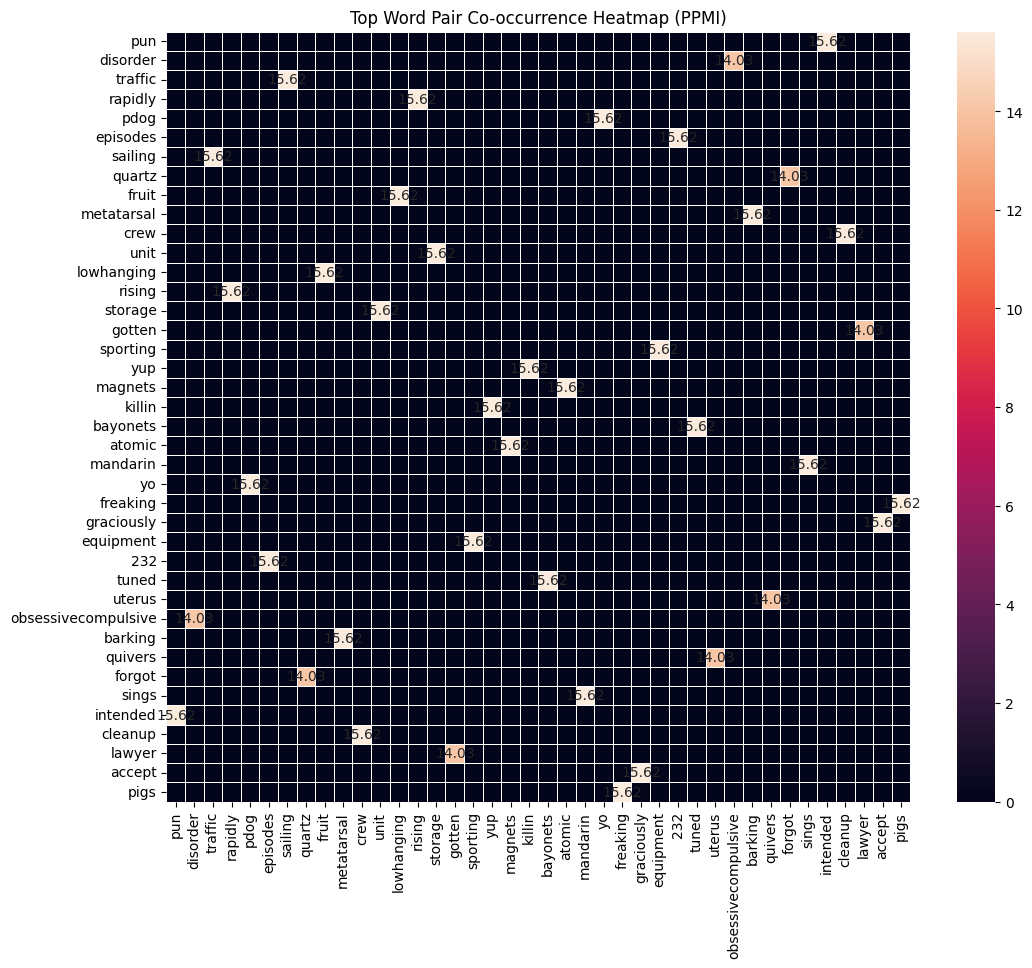

In [57]:
# Visualisation of the top 20 pair of words based on a window size of 2. 
word_pair_heatmap(ppmi_matrix, top_pairs, word_to_id)

# 